In [10]:
import io
from typing import List
from dataclasses import dataclass

import numpy as np
import cv2
import onnxruntime
import albumentations as A
from onemetric.cv.utils.iou import box_iou_batch

# Local packages
from tracker.byte_tracker import STrack, BYTETracker


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False
      
    
class Yolov5Detector():
    score_threshold = 0.1
    nms_threshold = 0.1

    def __init__(self, model_path='best.onnx', size=(1280, 1280), classes={0: 'face'}) -> None:
        """
        Initialize the MyDetector object.

        Args:
            model_path (str): Path to the model file.
            size (tuple): Size of the input image.

        Returns:
            None
        """
        self._session = onnxruntime.InferenceSession(model_path)
        self.input_name = self._session.get_inputs()[0].name
        self.output_names = [self._session.get_outputs()[0].name]
        self._size = size
        self.classes = classes
        
    def _preprocess(self, rgb_img):
        """
        Performs preprocessing transformation for model.

        Args:
            rgb_img (numpy.ndarray): Input RGB image.

        Returns:
            numpy.ndarray: Output of the transformation.
        """
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        normalize_transform = A.Compose([
            A.Normalize(mean=mean, std=std),
            A.LongestMaxSize(max_size=self._size[0]),
            A.PadIfNeeded(min_height=self._size[0], min_width=self._size[0], border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
        ])
        resize_transform = A.Compose([
            A.LongestMaxSize(max_size=self._size[0]),
            A.PadIfNeeded(min_height=self._size[0], min_width=self._size[0], border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
        ])
        # Применение аугментации к изображению
        return normalize_transform(image=rgb_img)['image'], resize_transform(image=rgb_img)['image']
        
    
    def forward(self, rgb_img):
        """
        Performs forward pass on the input image.

        Args:
            rgb_img (numpy.ndarray): Preprocessed input RGB image.

        Returns:
            numpy.ndarray: Output of the forward pass.
        """
        input_image = np.expand_dims(rgb_img, axis=0).astype('float32')
        input_image = np.transpose(input_image, [0, 3, 1, 2])
        return self._session.run(None, {self.input_name: input_image})[0][0]
    
    
    def post_process(self, output):
        """
        Post-process the output of the model.

        Args:
            output (tuple): Output of the model.

        Returns:
            tuple: Processed bounding boxes and class IDs.
        """
        # Извлечение ограничивающих рамок, оценок достоверности и вероятностей классов
        boxes = output[:, :4].astype(np.float32)  # Форма [num_detections, 4]
        scores = output[:, 4].astype(np.float32)  # Форма [num_detections]
        # Преобразование ограничивающих рамок в формат [x1, y1, x2, y2]
        boxes = np.array([
            (cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2)
            for cx, cy, w, h in boxes
        ])
        keep = cv2.dnn.NMSBoxes(boxes, scores.tolist(), self.score_threshold, self.nms_threshold)
        return boxes[keep], scores[keep]
    
    
    def draw_detections(self, img, box, score, class_id=0, tracker_id=None):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.
            tracker_id: Tracking ID of bbox 

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, x2, y2 = box

        # Create the label text with class name and score
        keep = True
        try: 
            if tracker_id is None:
                label = f"face: {score:.2f}"
            else: 
                label = f"#{tracker_id} score: {score:.2f}"
        except KeyError:
            keep = False
        if keep:
            # Retrieve the color for the class ID
            color = (0, 128, 0) # green
            font_scale = 1.3
            # Draw the bounding box on the image
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

            # Calculate the dimensions of the label text
            (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)

            # Calculate the position of the label text
            label_x = x1
            label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

            # Draw a filled rectangle as the background for the label text
            cv2.rectangle(
                img,
                (int(label_x), int(label_y - label_height)),
                (int(label_x + label_width), int(label_y + label_height)),
                color,
                cv2.FILLED,
            )

            # Draw the label text on the image
            cv2.putText(img, label, (int(label_x), int(label_y)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), 1, cv2.LINE_AA)

            
    def draw_box(self, img):
        """
        Draw bounding boxes on the input image.

        Args:
            img (numpy.ndarray): Input image.

        Returns:
            numpy.ndarray: Image with bounding boxes drawn.
        """
        preprocessed_img, resized_img = self._preprocess(img)
        bboxes, scores = self.post_process(self.forward(preprocessed_img))

        for xyxy, score in zip(bboxes, scores):
            self.draw_detections(img=resized_img, box=xyxy, score=score)

        # Преобразование изображения в формат RGB для matplotlib
        return cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    
    
    def _match_detections_with_tracks(self, xyxy, tracks):
        """
        Matches bboxes with predictions

        Args:
            xyxy numpy.ndarray: Input bboxes.

        Returns:
            numpy.ndarray: Tracker indexes for every bbox, may contain None objects if bbox is not being tracked.
        """
        if not np.any(xyxy) or len(tracks) == 0:
            return np.empty((0,))

        # converts List[STrack] into format that can be consumed by self._match_detections_with_tracks function
        tracks_boxes = np.array([track.tlbr for track in tracks], dtype=float)
        iou = box_iou_batch(tracks_boxes, xyxy)
        track2detection = np.argmax(iou, axis=1)

        tracker_ids = [None] * len(xyxy)

        for tracker_index, detection_index in enumerate(track2detection):
            if iou[tracker_index, detection_index] != 0:
                tracker_ids[detection_index] = tracks[tracker_index].track_id

        return np.array(tracker_ids)


    def video_run(self, cap):
        """
        Process video frames and draw bboxes.

        Args:
            cap: Video capture object.

        Returns:
            io.BytesIO: In-memory file containing the processed video.
        """
        # Create BYTETracker instance
        byte_tracker = BYTETracker(BYTETrackerArgs())
        
        # Video stream handling 
        output_memory_file = io.BytesIO()
        output_f = av.open(output_memory_file, 'w', format="mp4")  # Open "in memory file" as MP4 video output
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        stream = output_f.add_stream('h264', str(fps))  # Add H.264 video stream to the MP4 container, with framerate = fps.
        # Video capturing
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            preprocessed_img, resized_img = self._preprocess(frame)
            xyxy, confidence = self.post_process(self.forward(preprocessed_img))
#             print("first", xyxy[:3])
#             print("second", confidence[:3])
#             print("third", np.hstack((xyxy, confidence[:, np.newaxis])[:3]))
            # Tracking detections
            tracks = byte_tracker.update(
                output_results=np.hstack((xyxy, confidence[:, np.newaxis])),
                img_info=preprocessed_img.shape,
                img_size=preprocessed_img.shape
            )
            tracker_id = self._match_detections_with_tracks(xyxy, tracks)
            
            # Filtering out detections without trackers
            mask = np.array([idx is not None for idx in tracker_id], dtype=bool)
            xyxy = xyxy[mask]
            confidence = confidence[mask]
            tracker_id = tracker_id[mask]
            
            # Drawing bboxes with labels
            for box, score, idx in zip(xyxy, confidence, tracker_id):
                self.draw_detections(img=resized_img, box=box, score=score, tracker_id=idx)
            
            # Convert image from NumPy Array to frame.
            resized_img = av.VideoFrame.from_ndarray(resized_img, format='bgr24') 
            packet = stream.encode(resized_img)  # Encode video frame
            output_f.mux(packet)  # "Mux" the encoded frame (add the encoded frame to MP4 file).
            
        # Flush the encoder
        packet = stream.encode(None)
        output_f.mux(packet)
        output_f.close()
        return output_memory_file

    
    def __call__(self, rgb_img):
        """
        Call the MyDetector object to process an input image.

        Args:
            rgb_img (numpy.ndarray): Input RGB image.

        Returns:
            tuple: Processed bounding boxes and class IDs.
        """
        return self.draw_box(rgb_img)


In [3]:
import cv2
import av

# Define the path to the input video file
input_video_path = 'test_video.mp4'

# Define the path to the output video file
output_video_path = 'output_video.mp4'

# Open the input video file for reading
input_video = cv2.VideoCapture(input_video_path)

# Check if the video file was successfully opened
if not input_video.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Create an instance of the Yolov5Detector class
detector = Yolov5Detector()

# Process the video frames and save the processed video
with detector.video_run(input_video) as output_memory_file:
    with open(output_video_path, "wb") as f:
        f.write(output_memory_file.getbuffer())

# Release the input video file
input_video.release()

print("Video processing complete. Output video saved to:", output_video_path)


iou [[0.91074728]]
iou [[0.89690826]]
iou [[0.89726524]]
iou [[0.88811974]]
iou [[0.82161638]]
iou [[0.78253738]]
iou [[0.73667529]]
iou [[0.83430416]]
iou [[0.79107323]]
iou [[0.75726999]]
iou [[0.93373593 0.        ]]
iou [[0.         0.97191343]]
Video processing complete. Output video saved to: output_video.mp4


drawed


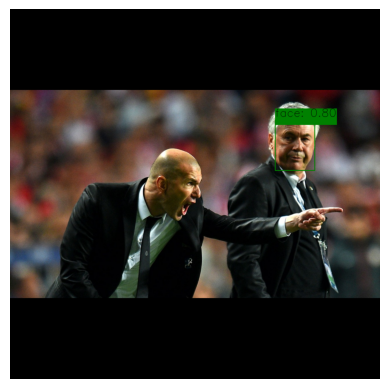

In [11]:
import matplotlib.pyplot as plt


# Создаем экземпляр детектора
detector = Yolov5Detector()

# Загружаем изображение для тестирования
image_path = 'zidane.jpg'
image = cv2.imread(image_path)

# Выполняем детекцию
result_image = detector(image)

# Отображаем результаты с помощью Matplotlib
plt.imshow(result_image)
plt.savefig('transformed_image.jpg')  # Save the image to a file
plt.axis('off')
plt.show()